# Car Object Detection

# Problem Overview

This notebook tackles **single object detection**. As the name suggests, single object detection entails the detection of a single object. More specifically, a model is tasked with providing the coordinates of the bounding box of an object in a particular image.

## Model Overview

Since we are asked to predict a set of numbers (the coordinates of the bounding box of an object), we can treat single object detection as a linear regression problem, except with an image as input. To handle the image, we can utilise a convolutional neural network (CNN).

Now that we have a fairly decent idea about how to approach this problem, we can get started with the setup.

## Setup

As usual, we'll start by importing some libraries.

In [19]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
from pathlib import Path
import requests
import zipfile
import io

Next, we'll setup our dataset.

In [20]:
url = 'https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/object-detection/archive.zip'

r = requests.get(url)
with zipfile.ZipFile(io.BytesIO(r.content), 'r') as zip_ref:
    zip_ref.extractall('./')

train_path = Path("data/training_images")
test_path = Path("data/testing_images")

Since `cv2`, the library we'll be using to plot the bounding boxes and the images, only accepts integer values as vertices, we'll need to convert the coordinates of the bounding boxes to integers.

The dataset contains information about multi-object detection; however, this notebook is concerned with single object detection. To account for this slight discrepancy, we will omit the duplicate values of the `image` column. This results in each image having only one corresponding set of bounding box coordinates. 

In [21]:
train = pd.read_csv("data/train_solution_bounding_boxes.csv")
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

Next, I'll create some utility functions that make it easy to display images from files and dataframes.

In [22]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)
    
    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)
        
    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)
        
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)
    
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)
    

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))
    
    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]
    
    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])

**A quick formatting note**: the green rectangle represents the correct bounding whereas the red rectangle represents the predicted bounding box. This convention is used throughout this notebook.

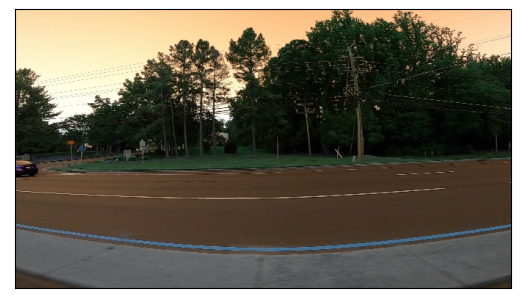

In [23]:
display_image_from_file("vid_4_10520.jpg")

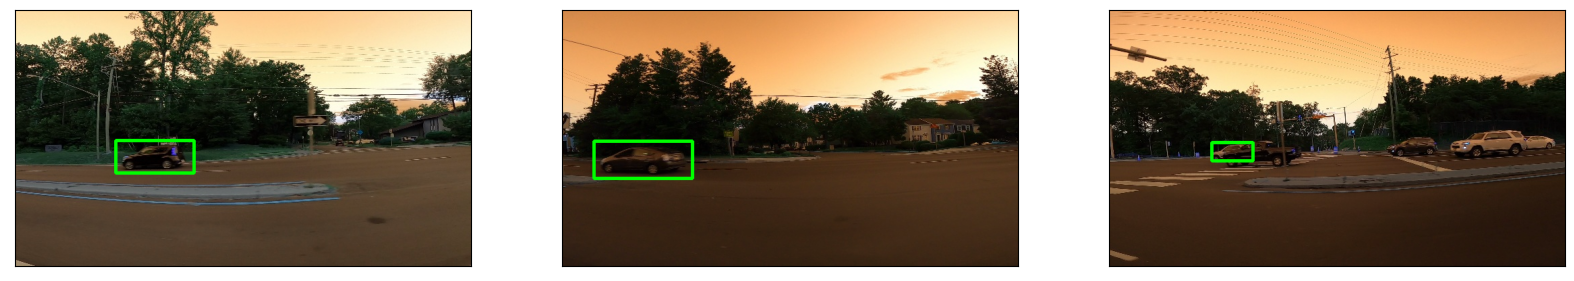

In [24]:
display_grid()

## Model Training

### Data Generator

Before training the model, we must define a generator that keras accepts. If you're not familiar with python generators or are in need of a quick refresher, check out [this resource](https://www.programiz.com/python-programming/generator).

In keras, all we need to do is initialize some arrays containing images and their corresponding bounding box coordinates. Then, we simply return the newly-created arrays in a dictionary.

In [25]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:        
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))
        
        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])
                
        yield {'image': images}, {'coords': bounding_box_coords}

The dictionary keys are crucial, as keras needs them to locate the correct input/output.

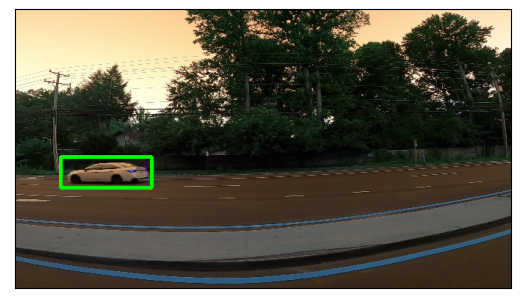

In [26]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

### Model Building

I'll use keras' functional API as it's incredibly easy to utilize custom inputs and predict custom outputs. Specifically, I'll use a fairly large neural network to start out with, and adjust the parameters of the layers if necessary.

Notice that the dictionary keys in the generator correspond to the names of the input and output layers.

In [27]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 380, 676, 8)       224       
                                                                 
 batch_normalization_20 (Ba  (None, 380, 676, 8)       32        
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 190, 338, 8)       0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_21 (Ba  (None, 190, 338, 16)      64  

Moving on, we'll compile the model.

For each output, we need to specify a loss and a metric. To do this, we simply reference the dictionary key used in the generator and assign it our desired loss function/metric.

In [28]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

Before we actually train the model, let's define a callback that tests the current model on three, randomly selected images.

In [29]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)
    
    X = example['image']
    y = label['coords']
    
    pred_bbox = model.predict(X)[0]
    
    img = X[0]
    gt_coords = y[0]
    
    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)
    
    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)    
    plt.show()
    
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

We'll quickly use these methods to evaluate the current performance of our model.

1/1 [==============================] - 0s 164ms/step


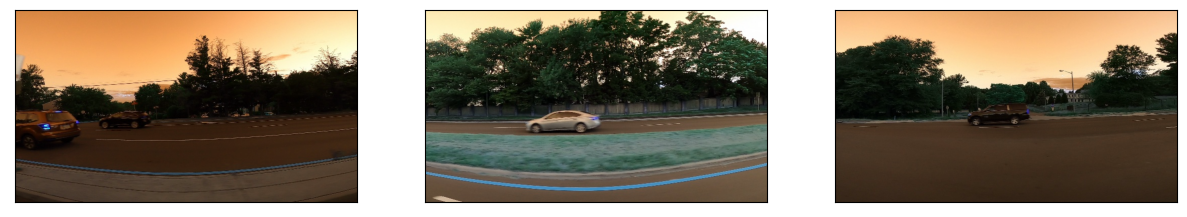

In [30]:
test(model)

The model isn't great; in fact, its predictions aren't even visible.

But, the model's poor performance is expected as we haven't even trained the model yet.
So, let's do just that.

Epoch 1/9
1/1 [==============================] - 0s 152ms/step


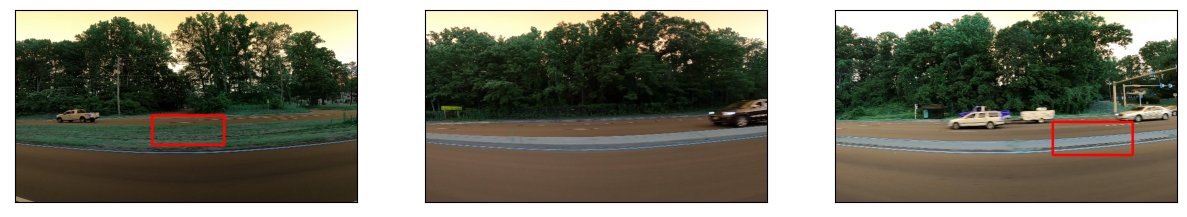

500/500 [==============================] - 3609s 7s/step - loss: 4362.1011 - accuracy: 0.8920
Epoch 2/9
1/1 [==============================] - 0s 155ms/step


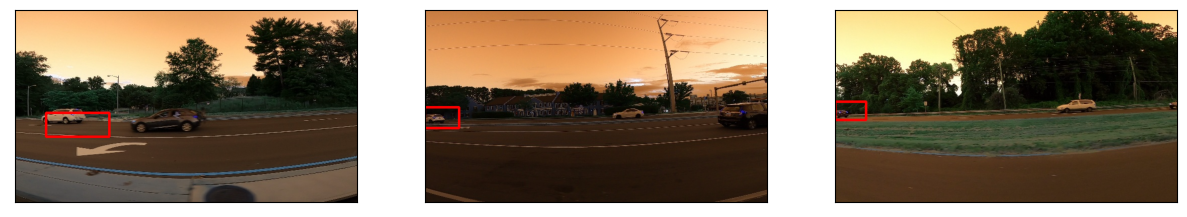

500/500 [==============================] - 3432s 7s/step - loss: 1008.8897 - accuracy: 0.9534
Epoch 3/9
1/1 [==============================] - 0s 201ms/step


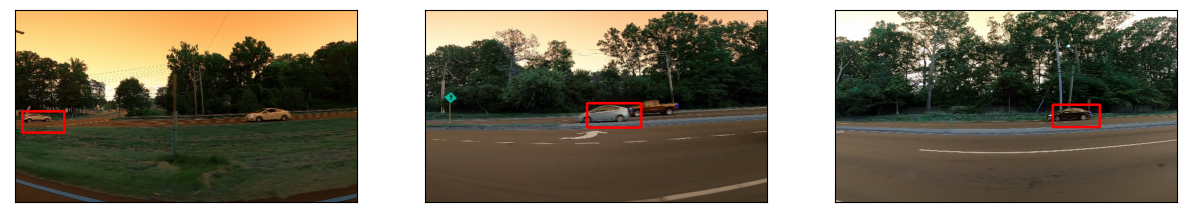

500/500 [==============================] - 3435s 7s/step - loss: 373.1008 - accuracy: 0.9750
Epoch 4/9
1/1 [==============================] - 0s 188ms/step


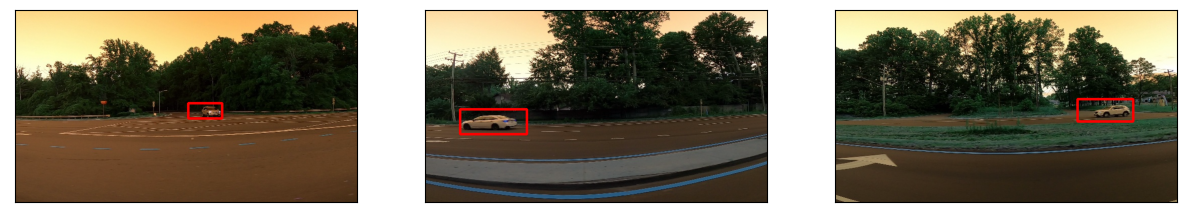

500/500 [==============================] - 3439s 7s/step - loss: 212.9883 - accuracy: 0.9855
Epoch 5/9
1/1 [==============================] - 0s 170ms/step


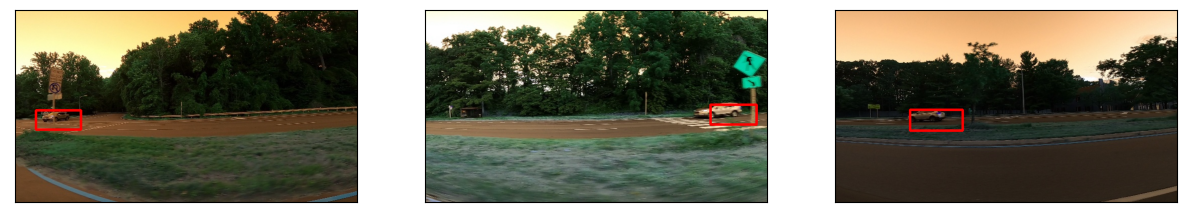

500/500 [==============================] - 3475s 7s/step - loss: 153.2819 - accuracy: 0.9894
Epoch 6/9
1/1 [==============================] - 0s 170ms/step


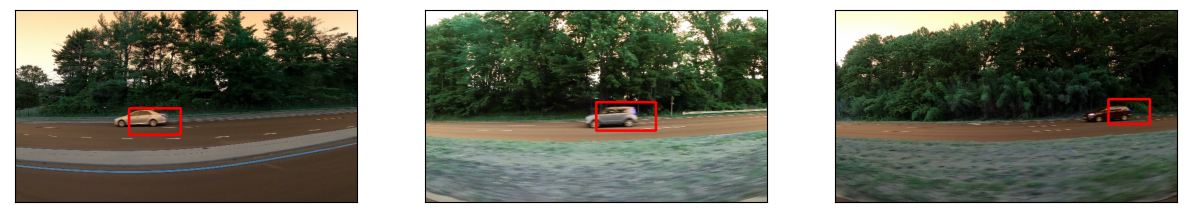

500/500 [==============================] - 3474s 7s/step - loss: 119.3525 - accuracy: 0.9876
Epoch 7/9
1/1 [==============================] - 0s 184ms/step


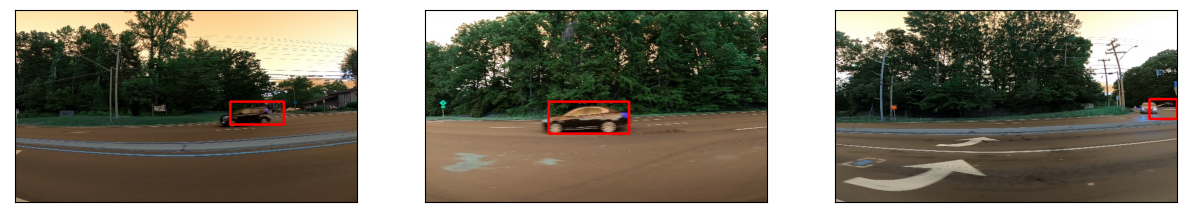

500/500 [==============================] - 3469s 7s/step - loss: 140.8651 - accuracy: 0.9890
Epoch 8/9
1/1 [==============================] - 0s 209ms/step


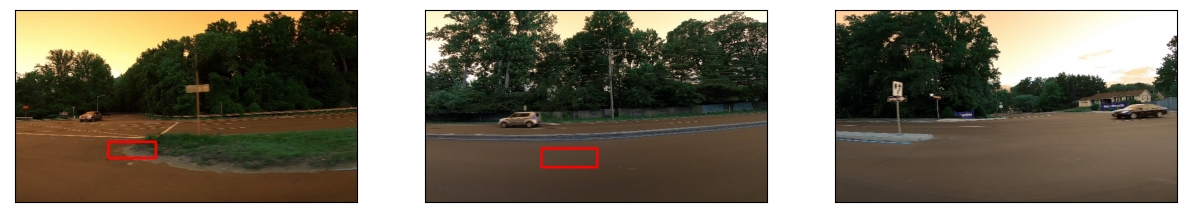

500/500 [==============================] - 3505s 7s/step - loss: 695.4883 - accuracy: 0.9750
Epoch 9/9
1/1 [==============================] - 0s 170ms/step


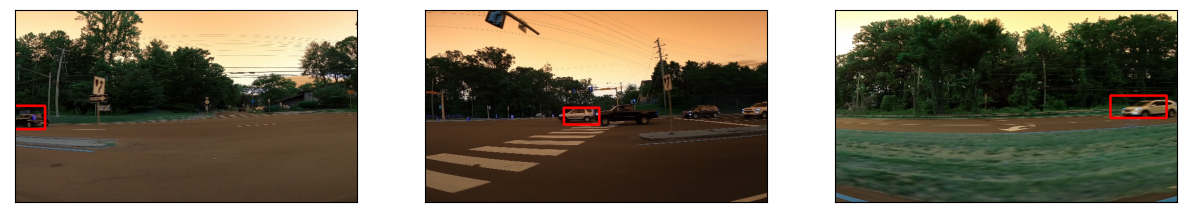

500/500 [==============================] - 3482s 7s/step - loss: 284.2846 - accuracy: 0.9784


In [31]:
_ = model.fit(
    data_generator(),
    epochs=9,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
    ]
)

The model is doing quite well; the `MSE` is relatively low and the accuracy is very high.

Since the model training seems to be complete, we can now export the model and store it for later use.

In [ ]:
model.save('car-object-detection.h5')

## Acknowledgments

Thanks to [Advay Patil](https://www.kaggle.com/advaypatil) for creating [Car Object Detection](https://www.kaggle.com/code/advaypatil/car-object-detection). It inspires the majority of the content in this chapter.